In [1]:

import math
from PIL import Image
from keras import layers
from keras.applications import ResNet50
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical# convert to one-hot-encoding
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline
from glob import glob
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model


color = sns.color_palette()
%matplotlib inline

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
#on adapte notre json file de notre kaggle profile
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"benlamlihothmane","key":"ebc68494200b00eb5534850edcf3ab77"}'}

In [5]:
!mkdir -p ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!ls ~/.kaggle

kaggle.json


In [8]:
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
#on se connecte a anotre kaggle data
!kaggle datasets download  "paultimothymooney/chest-xray-pneumonia"

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
#le fichier est zip , on va unsiper le fichier pour acceder anotre data
!unzip chest-xray-pneumonia.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-04

# Pneumonia

In [11]:
from IPython.display import Image 
Image(url="https://www.clinicbarcelona.org/uploads/media/default/0001/09/028fd0195b02b208a3118ea9797c3b2e37ed148f.png")

## c'est quoi la **pneumonie**?
La pneumonie est une infection pulmonaire qui cause de l’inflammation et des dommages aux tissus pulmonaires. Les poumons sont composés de passages (bronches) à travers lesquels l’air circule et de petits sacs (alvéoles) où l’échange de gaz se produit.<br/>
Chez une personne en bonne santé, les alvéoles se remplissent d’air pendant la respiration; cependant, chez les personnes atteintes de pneumonie, les alvéoles sont déjà remplies de pus et de liquide qui affecte les échanges gazeux.


## Types de **pneumonie**
**La pneumonie peut être classée en deux groupes selon la présentation clinique :**
Pneumonie d’origine communautaire (CAP). La pneumonie communautaire se caractérise par une apparition clinique rapide, une forte fièvre, des douleurs d’un côté ou des douleurs abdominales transitoires, une respiration rapide (tachypnoea), une toux et un flegme purulent ou brunâtre. Un exemple de ce type commun de présentation est la pneumonie induite par Streptococcus pneumoniae (pneumocoque), qui est considéré comme le principal micro-organisme causant la pneumonie dans le monde entier.<br/>
Pneumonie contractée dans la communauté avec une présentation clinique atypique. Elle se caractérise par un début moins aigu, une faible fièvre, une toux à peine productive (sèche), de la diarrhée et/ou des vomissements. Les pneumonies causées par des bactéries intracellulaires, par exemple Mycoplasma pneumoniae ou Legionella pneumophila, sont connues comme des pneumonies atypiques en raison de leur présentation inhabituelle.


# data

**chemin**

In [12]:
# Définir le chemin vers le répertoire de données
data_dir = Path('/content/chest_xray')

# Chemin vers le répertoire de données de train
train_dir = data_dir / 'train'

# Chemin vers le répertoire de données de validation
val_dir = data_dir / 'val'

# Chemin vers le répertoire de données de teste
test_dir = data_dir / 'test'

## visualisation

### cas normal

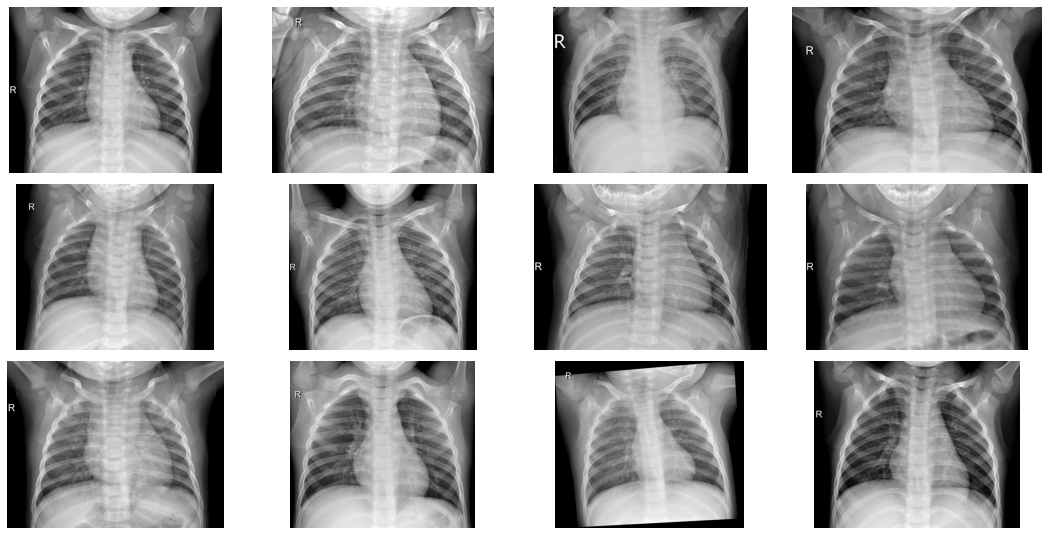

In [13]:
path = "/content/chest_xray/chest_xray/train/NORMAL"
#listdir =retourne une liste contenant les noms des entrées dans le répertoire donné par chemin
data_exemple = os.listdir(path)
plt.figure(figsize=(15, 10))

for i in range(12):
    plt.subplot(4, 4, i + 1)
    #imread =charge une image à partir du fichier spécifié
    img = plt.imread(os.path.join(path, data_exemple[i]))
    #imshow = affiche l'imagerie 
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

### cas pneumonia

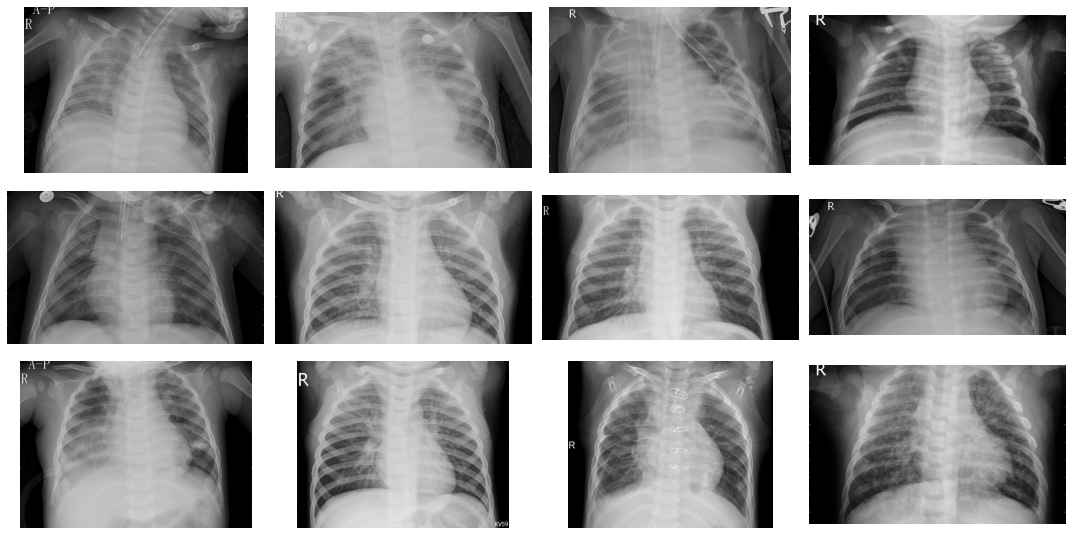

In [14]:
path = "/content/chest_xray/chest_xray/train/PNEUMONIA"
#listdir =retourne une liste contenant les noms des entrées dans le répertoire donné par chemin
data_exemple = os.listdir(path)
plt.figure(figsize=(15, 10))

for i in range(12):
    plt.subplot(4, 4, i + 1)
    #imread =charge une image à partir du fichier spécifié
    img = plt.imread(os.path.join(path, data_exemple[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

## Préparation des données

**validation**

In [15]:
#listdir =retourne une liste contenant les noms des entrées dans le répertoire donné par chemin
print("PNEUMONIA=",len(os.listdir(os.path.join(val_dir, 'PNEUMONIA'))))
print("NORMAL=",len(os.listdir(os.path.join(val_dir, 'NORMAL'))))

PNEUMONIA= 8
NORMAL= 8


**test**

In [16]:
#listdir =retourne une liste contenant les noms des entrées dans le répertoire donné par chemin
print("PNEUMONIA=",len(os.listdir(os.path.join(test_dir, 'PNEUMONIA'))))
print("NORMAL=",len(os.listdir(os.path.join(test_dir, 'NORMAL'))))

PNEUMONIA= 390
NORMAL= 234


**trainement**

In [17]:
#listdir =retourne une liste contenant les noms des entrées dans le répertoire donné par chemin
print("PNEUMONIA=",len(os.listdir(os.path.join(train_dir, 'PNEUMONIA'))))
print("NORMAL=",len(os.listdir(os.path.join(train_dir, 'NORMAL'))))

PNEUMONIA= 3875
NORMAL= 1341


Chacun des répertoires contient deux sous-répertoires:


*   **PNEUMONIE**: Ce répertoire contient les échantillons qui sont les cas de pneumonie.
*   **NORMAL**: Ce sont les échantillons qui décrivent le cas normal (pas de pneumonie).


### Préparation des données de trainement




In [18]:
#Récupérer le chemin  
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

#Obtenez la liste de toutes les images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

In [19]:
#Nous insérerons les données dans une liste vide x et y
train_data = []
count=0
# Passez en tous les cas normaux
for img in normal_cases:
    train_data.append((img,1,0))

In [20]:
# Passez en tous les cas pneumonie
for img in pneumonia_cases:
    if count <1501 :
      train_data.append((img,0,1))
      count = count + 1

In [21]:
#nomée les atribut du tableau train_data
train_data = pd.DataFrame(train_data, columns=['image', 'NORMAL','PNEUMONIA'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

train_data.head()

,image,NORMAL,PNEUMONIA
0,/content/chest_xray/train/PNEUMONIA/person614_...,0,1
1,/content/chest_xray/train/PNEUMONIA/person881_...,0,1
2,/content/chest_xray/train/NORMAL/IM-0640-0001-...,1,0
3,/content/chest_xray/train/PNEUMONIA/person500_...,0,1
4,/content/chest_xray/train/NORMAL/NORMAL2-IM-12...,1,0


In [22]:
train_data['PNEUMONIA']

0       1
1       1
2       0
3       1
4       0
       ..
2837    1
2838    0
2839    1
2840    1
2841    0
Name: PNEUMONIA, Length: 2842, dtype: int64

0    1501
1    1341
Name: NORMAL, dtype: int64


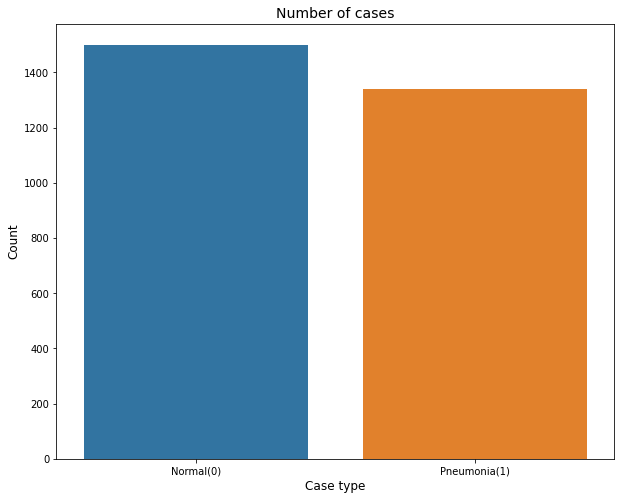

In [23]:
# conter le nombre data
cases_count = train_data['NORMAL'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), [ 'Normal(0)','Pneumonia(1)'])
plt.show()

In [24]:
cases_count

0    1501
1    1341
Name: NORMAL, dtype: int64

Comme vous pouvez le voir, les données sont très déséquilibrées. Nous avons presque trois cas de pneumonie ici par rapport aux cas normaux. Cette situation est tout à fait normale en ce qui concerne les données médicales. Les données seront toujours déséquilibrées. soit il y aura trop de cas normaux, soit il y aura trop de cas avec la maladie.

### Préparation des données de validation

### Préparation des données de test

In [25]:
#Récupérer le chemin  
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

#Obtenez la liste de toutes les images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
#Nous insérerons les données dans une liste vide x et y
val_data = []

#Nous insérerons les données dans une liste vide x et y
test_data = []
count = 0
# Passez en tous les cas normaux(Référencier par 0  )
for img in normal_cases:
    if  count < 134 :
      test_data.append((img,1,0))
      count = count +1 
    else :
      val_data.append((img,1,0))

count = 0   

# Passez en tous les cas pneumonie(Référencier par 1  )
for img in pneumonia_cases:
    if  count < 290 :
      test_data.append((img,0,1))
      count = count +1 
    else :
      val_data.append((img,0,1))


test_data = pd.DataFrame(test_data, columns=['image', 'NORMAL','PNEUMONIA'],index=None)

#Mélangez les données
test_data = test_data.sample(frac=1.).reset_index(drop=True)

#afficher
test_data.head()

,image,NORMAL,PNEUMONIA
0,/content/chest_xray/test/NORMAL/IM-0097-0001.jpeg,1,0
1,/content/chest_xray/test/PNEUMONIA/person1612_...,0,1
2,/content/chest_xray/test/PNEUMONIA/person69_vi...,0,1
3,/content/chest_xray/test/NORMAL/NORMAL2-IM-030...,1,0
4,/content/chest_xray/test/PNEUMONIA/person85_ba...,0,1


In [26]:
#Récupérer le chemin  
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

#Obtenez la liste de toutes les images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')


# Passez en tous les cas normaux(Référencier par 0  )
for img in normal_cases:
    val_data.append((img,1,0))


# Passez en tous les cas pneumonie(Référencier par 1  )
for img in pneumonia_cases:
    val_data.append((img,0,1))


val_data = pd.DataFrame(val_data, columns=['image','NORMAL','PNEUMONIA'],index=None)

#Mélangez les données
val_data = val_data.sample(frac=1.).reset_index(drop=True)

#afficher
val_data.head()

,image,NORMAL,PNEUMONIA
0,/content/chest_xray/test/PNEUMONIA/person155_b...,0,1
1,/content/chest_xray/val/PNEUMONIA/person1951_b...,0,1
2,/content/chest_xray/test/PNEUMONIA/person120_b...,0,1
3,/content/chest_xray/test/PNEUMONIA/person91_ba...,0,1
4,/content/chest_xray/test/NORMAL/NORMAL2-IM-013...,1,0


In [27]:
val_data.shape

(216, 3)

In [28]:
#input de validation
val_data['image'].shape

(216,)

In [29]:
val_data['NORMAL'].shape

(216,)

alors aucune valeur manquante

In [30]:
# lancer un conteure pour chaque attribut
cases_count = val_data['NORMAL'].value_counts()
print(cases_count)

1    108
0    108
Name: NORMAL, dtype: int64


In [31]:
cases_count.index

Int64Index([1, 0], dtype='int64')

In [32]:
cases_count.values

array([108, 108])

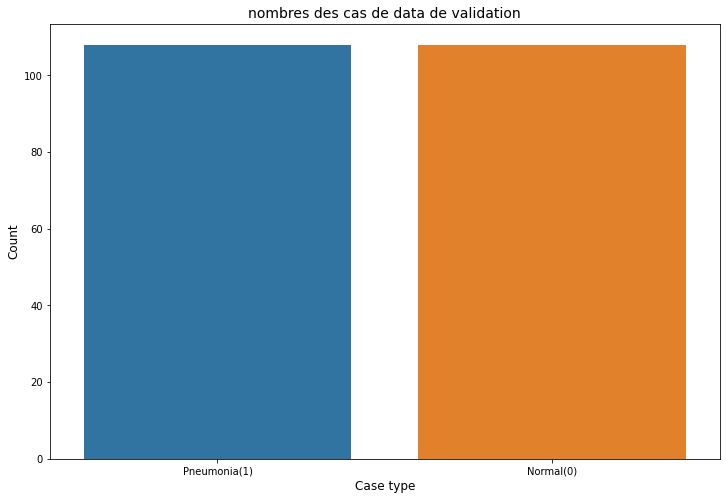

In [33]:
plt.figure(figsize=(12,8))
#x = soit 0 soit 1 
#y = la somme de chaque type
sns.barplot(x=cases_count.index, y= cases_count.values)

plt.title('nombres des cas de data de validation', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
#renomer les label de x 
plt.xticks(range(len(cases_count.index)), ['Pneumonia(1)','Normal(0)'])
plt.show()

In [34]:
test_data.shape

(424, 3)

In [35]:
train_data.shape

(2842, 3)

In [36]:

cases_count = val_data['NORMAL'].value_counts()
print(cases_count)

1    108
0    108
Name: NORMAL, dtype: int64


In [37]:
cases_count.index

Int64Index([1, 0], dtype='int64')

In [38]:
cases_count.values

array([108, 108])

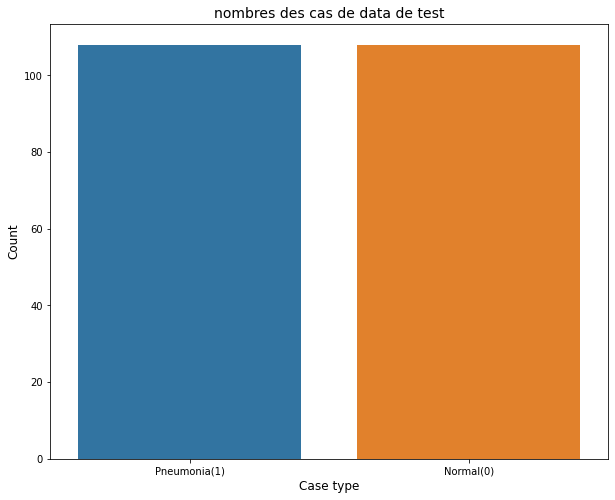

In [39]:
plt.figure(figsize=(10,8))
#x = soit 0 soit 1 
#y = la somme de chaque type
sns.barplot(x=cases_count.index, y= cases_count.values)

plt.title('nombres des cas de data de test', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
#renomer les label de x 
plt.xticks(range(len(cases_count.index)), ['Pneumonia(1)','Normal(0)'])
plt.show()

### visualisation data

In [40]:
#on va prendre quelque exemplaire
pneumonia_samples = (train_data[train_data['PNEUMONIA']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['NORMAL']==1]['image'].iloc[:5]).tolist()

#on cree une data de c'est exemple
samples = pneumonia_samples + normal_samples

#on affiche
def affiche(samples):
  f, ax = plt.subplots(2,5, figsize=(30,10))
  for i in range(10):
      img = imread(samples[i])
      ax[i//5, i%5].imshow(img, cmap='gray')
      if i<5:
          ax[i//5, i%5].set_title("Pneumonia")
      else:
          ax[i//5, i%5].set_title("Normal")
      ax[i//5, i%5].axis('off')
      ax[i//5, i%5].set_aspect('auto')
  plt.show()

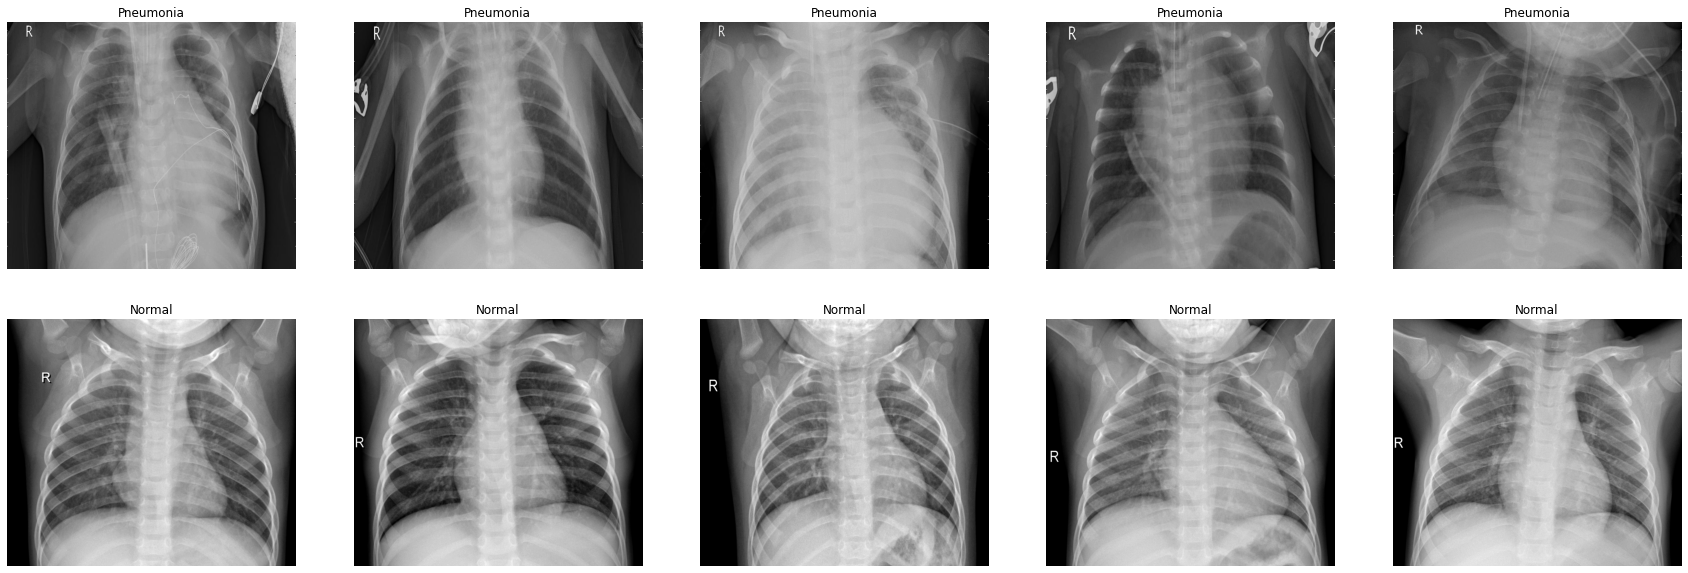

In [41]:
affiche(samples)

# VGG16 Model

In [42]:
from keras.applications.vgg16 import VGG16

In [43]:
#la taille de notre input
taille=(224, 224,3)
#importer le model vgg16
model_vgg16 = VGG16(input_shape=taille, include_top=False, weights='imagenet')

In [44]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## construction du modele

In [45]:
# Freeze the base_model
model_vgg16.trainable = False

In [46]:
model_vgg16.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [47]:
# ajouter un MaxPooling2D
x = layers.GlobalMaxPooling2D()(model_vgg16.output)
# ajouter une couche a  512 et ReLU comme activation
x = layers.Dense(512, activation='relu')(x)
# ajouter dropout rate of 0.5
x = layers.Dropout(0.2)(x)
# Ajout d’une couche entièrement connectée avec 256 unités cachées et activation ReLU
x = layers.Dense(256, activation='relu')(x)
# Ajout d’une couche entièrement connectée avec 128 unités cachées et activation ReLU
x = layers.Dense(128, activation='relu')(x)
# Ajouter une couche sigmoïde finale pour la classification
x = layers.Dense(2, activation='softmax')(x)

# Configurer et compiler le modèle
model = Model(model_vgg16.input, x)


In [48]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## gestion de data

In [49]:
train_data.head()

,image,NORMAL,PNEUMONIA
0,/content/chest_xray/train/PNEUMONIA/person614_...,0,1
1,/content/chest_xray/train/PNEUMONIA/person881_...,0,1
2,/content/chest_xray/train/NORMAL/IM-0640-0001-...,1,0
3,/content/chest_xray/train/PNEUMONIA/person500_...,0,1
4,/content/chest_xray/train/NORMAL/NORMAL2-IM-12...,1,0


In [50]:
x_train_data = []
y_train_data = []

for img in train_data['NORMAL']:
    if img == 1:
      y_train_data.append((1,0))
    else:
      y_train_data.append((0,1))

for img in train_data['image']:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    img = img.astype(np.float32)/255
    x_train_data.append(img)


In [51]:
x_train_data=np.array(x_train_data)
y_train_data=np.array(y_train_data)

In [52]:
x_train_data.shape

(2842, 224, 224, 3)

In [53]:
y_train_data.shape

(2842, 2)

In [54]:
x_val_data = []
y_val_data = []

for img in val_data['NORMAL']:
    if img == 1:
      y_val_data.append((1,0))
    else:
      y_val_data.append((0,1))

for img in val_data['image']:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    img = img.astype(np.float32)/255
    x_val_data.append(img)




In [55]:
x_val_data=np.array(x_val_data)
y_val_data=np.array(y_val_data)

In [56]:
y_val_data.shape

(216, 2)

In [57]:
x_val_data.shape

(216, 224, 224, 3)

In [58]:
x_test_data = []
y_test_data = []

for img in test_data['NORMAL']:
    if img == 1:
      y_test_data.append((1,0))
    else:
      y_test_data.append((0,1))

for img in test_data['image']:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    img = img.astype(np.float32)/255
    x_test_data.append(img)

x_test_data=np.array(x_val_data)
y_test_data=np.array(y_val_data)

In [59]:
x_test_data.shape

(216, 224, 224, 3)

## Data Augmentation

In [60]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train_data)
#datagen.fit(y_train_data)
datagen.fit(x_val_data)
#datagen.fit(y_val_data)

In [61]:
#datagen.fit(x_train_data)

In [62]:
callbacks1 = [
    EarlyStopping(monitor='val_loss', patience=6, mode='min', verbose=1),
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, min_lr=0.00001, verbose=1, mode='min'),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
    ]


In [63]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [64]:
import time 
start = time.time()
history_vgg16 = model.fit(datagen.flow(x_train_data,y_train_data, batch_size = 124) ,epochs = 12 , validation_data = datagen.flow(x_val_data, y_val_data ,batch_size = 64 ) ,callbacks = [callbacks1])
stop = time.time()

Epoch 1/12
23/23 [==============================] - 37s 1s/step - loss: 0.8172 - accuracy: 0.5654 - val_loss: 0.4587 - val_accuracy: 0.8009

Epoch 00001: val_loss improved from inf to 0.45872, saving model to best_model.h5
Epoch 2/12
23/23 [==============================] - 30s 1s/step - loss: 0.3018 - accuracy: 0.8862 - val_loss: 0.5136 - val_accuracy: 0.8148

Epoch 00002: val_loss did not improve from 0.45872
Epoch 3/12
23/23 [==============================] - 30s 1s/step - loss: 0.2571 - accuracy: 0.8995 - val_loss: 0.4294 - val_accuracy: 0.8333

Epoch 00003: val_loss improved from 0.45872 to 0.42941, saving model to best_model.h5
Epoch 4/12
23/23 [==============================] - 30s 1s/step - loss: 0.2154 - accuracy: 0.9231 - val_loss: 0.5713 - val_accuracy: 0.7778

Epoch 00004: val_loss did not improve from 0.42941
Epoch 5/12
23/23 [==============================] - 30s 1s/step - loss: 0.2013 - accuracy: 0.9233 - val_loss: 0.4007 - val_accuracy: 0.8426

Epoch 00005: val_loss imp

In [67]:
print(f"Training time: {stop - start}s")

Training time: 370.4955503940582s


In [68]:
print("Loss of the model is - " , model.evaluate(x_test_data,y_test_data)[0])
print("Accuracy of the model is - " , model.evaluate(x_test_data,y_test_data)[1]*100 , "%")

7/7 [==============================] - 0s 66ms/step - loss: 0.3158 - accuracy: 0.8704
Loss of the model is -  0.3157632648944855
7/7 [==============================] - 0s 65ms/step - loss: 0.3158 - accuracy: 0.8704
Accuracy of the model is -  87.03703880310059 %
